In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load and preprocess data
def load_data(file_path):
    data = pd.read_csv(file_path)
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data.set_index('timestamp', inplace=True)
    return data

In [3]:
# Compute Bollinger Bands
def compute_bollinger_bands(data, period, multiplier):
    data['SMA'] = data['Close'].rolling(window=period).mean()
    data['STD'] = data['Close'].rolling(window=period).std()
    data['Upper Band'] = data['SMA'] + (multiplier * data['STD'])
    data['Lower Band'] = data['SMA'] - (multiplier * data['STD'])
    data.dropna(inplace=True)
    return data

In [4]:
# Simulate trading strategy
def simulate_strategy(data, x_bars, stop_loss, starting_capital):
    capital = starting_capital
    position = 0
    entry_price = 0
    stop_loss_price = 0
    number_of_trades = 0
    trade_results = []
    equity_curve = [capital]

    for i in range(period, len(data)):
        current_date = data.index[i]
        if position == 0 and data['Close'].iloc[i] > data['Upper Band'].iloc[i]:
            # Enter a long position
            position = 1
            entry_price = data['Close'].iloc[i]
            entry_date = current_date
            stop_loss_price = entry_price * (1 - stop_loss)
            number_of_trades += 1
        elif position == 1:
            # Check stop loss
            if data['Close'].iloc[i] <= stop_loss_price:
                exit_price = stop_loss_price
                trade_results.append((entry_price, exit_price, 'Stop Loss'))
                capital *= 1 + (exit_price - entry_price) / entry_price
                equity_curve.append(capital)
                position = 0
            # Check holding period
            elif (current_date - entry_date).days >= x_bars:
                exit_price = data['Close'].iloc[i]
                trade_results.append((entry_price, exit_price, 'Exit after x_bars'))
                capital *= 1 + (exit_price - entry_price) / entry_price
                equity_curve.append(capital)
                position = 0

    # Calculate performance metrics
    equity_curve = np.array(equity_curve)
    returns = np.diff(equity_curve) / equity_curve[:-1]
    cumulative_returns = np.cumprod(1 + returns) - 1
    total_return = cumulative_returns[-1] * 100
    peak = np.maximum.accumulate(equity_curve)
    drawdowns = (equity_curve - peak) / peak
    max_drawdown = drawdowns.min() * 100
    sharpe_ratio = np.mean(returns) / np.std(returns) if np.std(returns) != 0 else 0
    wins = sum(1 for entry, exit, reason in trade_results if exit > entry)
    winrate = wins / number_of_trades if number_of_trades > 0 else 0
    gross_profit = sum(exit - entry for entry, exit, reason in trade_results if exit > entry)
    gross_loss = sum(entry - exit for entry, exit, reason in trade_results if exit < entry)
    profit_factor = gross_profit / gross_loss if gross_loss != 0 else float('inf')
    exposure_time = (x_bars * number_of_trades) / len(data) * 100

    return {
        'Total Return (%)': total_return,
        'Max Drawdown (%)': max_drawdown,
        'Win Rate (%)': winrate * 100,
        'Profit Factor': profit_factor,
        'Sharpe Ratio': sharpe_ratio,
        'Number of Trades': number_of_trades,
        'Exposure Time (%)': exposure_time
    }

In [5]:
# Generate heatmaps
def plot_heatmaps(results_df, keys):
    heatmap_data = {key: results_df.pivot(index='x_bars', columns='Multiplier', values=key) for key in keys}
    n_cols = 2
    n_rows = int(np.ceil(len(keys) / n_cols))

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axs = axs.ravel()

    for i, key in enumerate(keys):
        sns.heatmap(
            heatmap_data[key], 
            annot=True, fmt=".2f", cmap="coolwarm", ax=axs[i], 
            cbar_kws={'label': key}
        )
        axs[i].set_title(key)
        axs[i].set_xlabel('Multiplier')
        axs[i].set_ylabel('x_bars')

    for j in range(len(keys), len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

In [6]:
# Execution
data = load_data('btc_in_sample_data.csv')
period = 20
stop_loss = 0.2
starting_capital = 10000
multipliers = [0, 0.5, 1, 1.5, 2, 2.5]
x_bars_range = [5, 10, 20, 40, 80, 160]

results = []

for multiplier in multipliers:
    data = compute_bollinger_bands(data, period, multiplier)
    for x_bars in x_bars_range:
        metrics = simulate_strategy(data, x_bars, stop_loss, starting_capital)
        metrics.update({'Multiplier': multiplier, 'x_bars': x_bars})
        results.append(metrics)

results_df = pd.DataFrame(results)
print(results_df.head())

   Total Return (%)  Max Drawdown (%)  Win Rate (%)  Profit Factor  \
0         80.310138        -83.781431     49.869452       1.009309   
1        361.793930        -76.914834     52.000000       1.089088   
2        471.235597        -74.209748     52.336449       1.079350   
3        407.363543        -71.355403     47.540984       1.122855   
4        344.564221        -71.000211     38.461538       1.137965   

   Sharpe Ratio  Number of Trades  Exposure Time (%)  Multiplier  x_bars  
0      0.063393               383           4.077765         0.0       5  
1      0.121008               200           4.258762         0.0      10  
2      0.173109               107           4.556876         0.0      20  
3      0.216071                61           5.195690         0.0      40  
4      0.233706                39           6.643669         0.0      80  


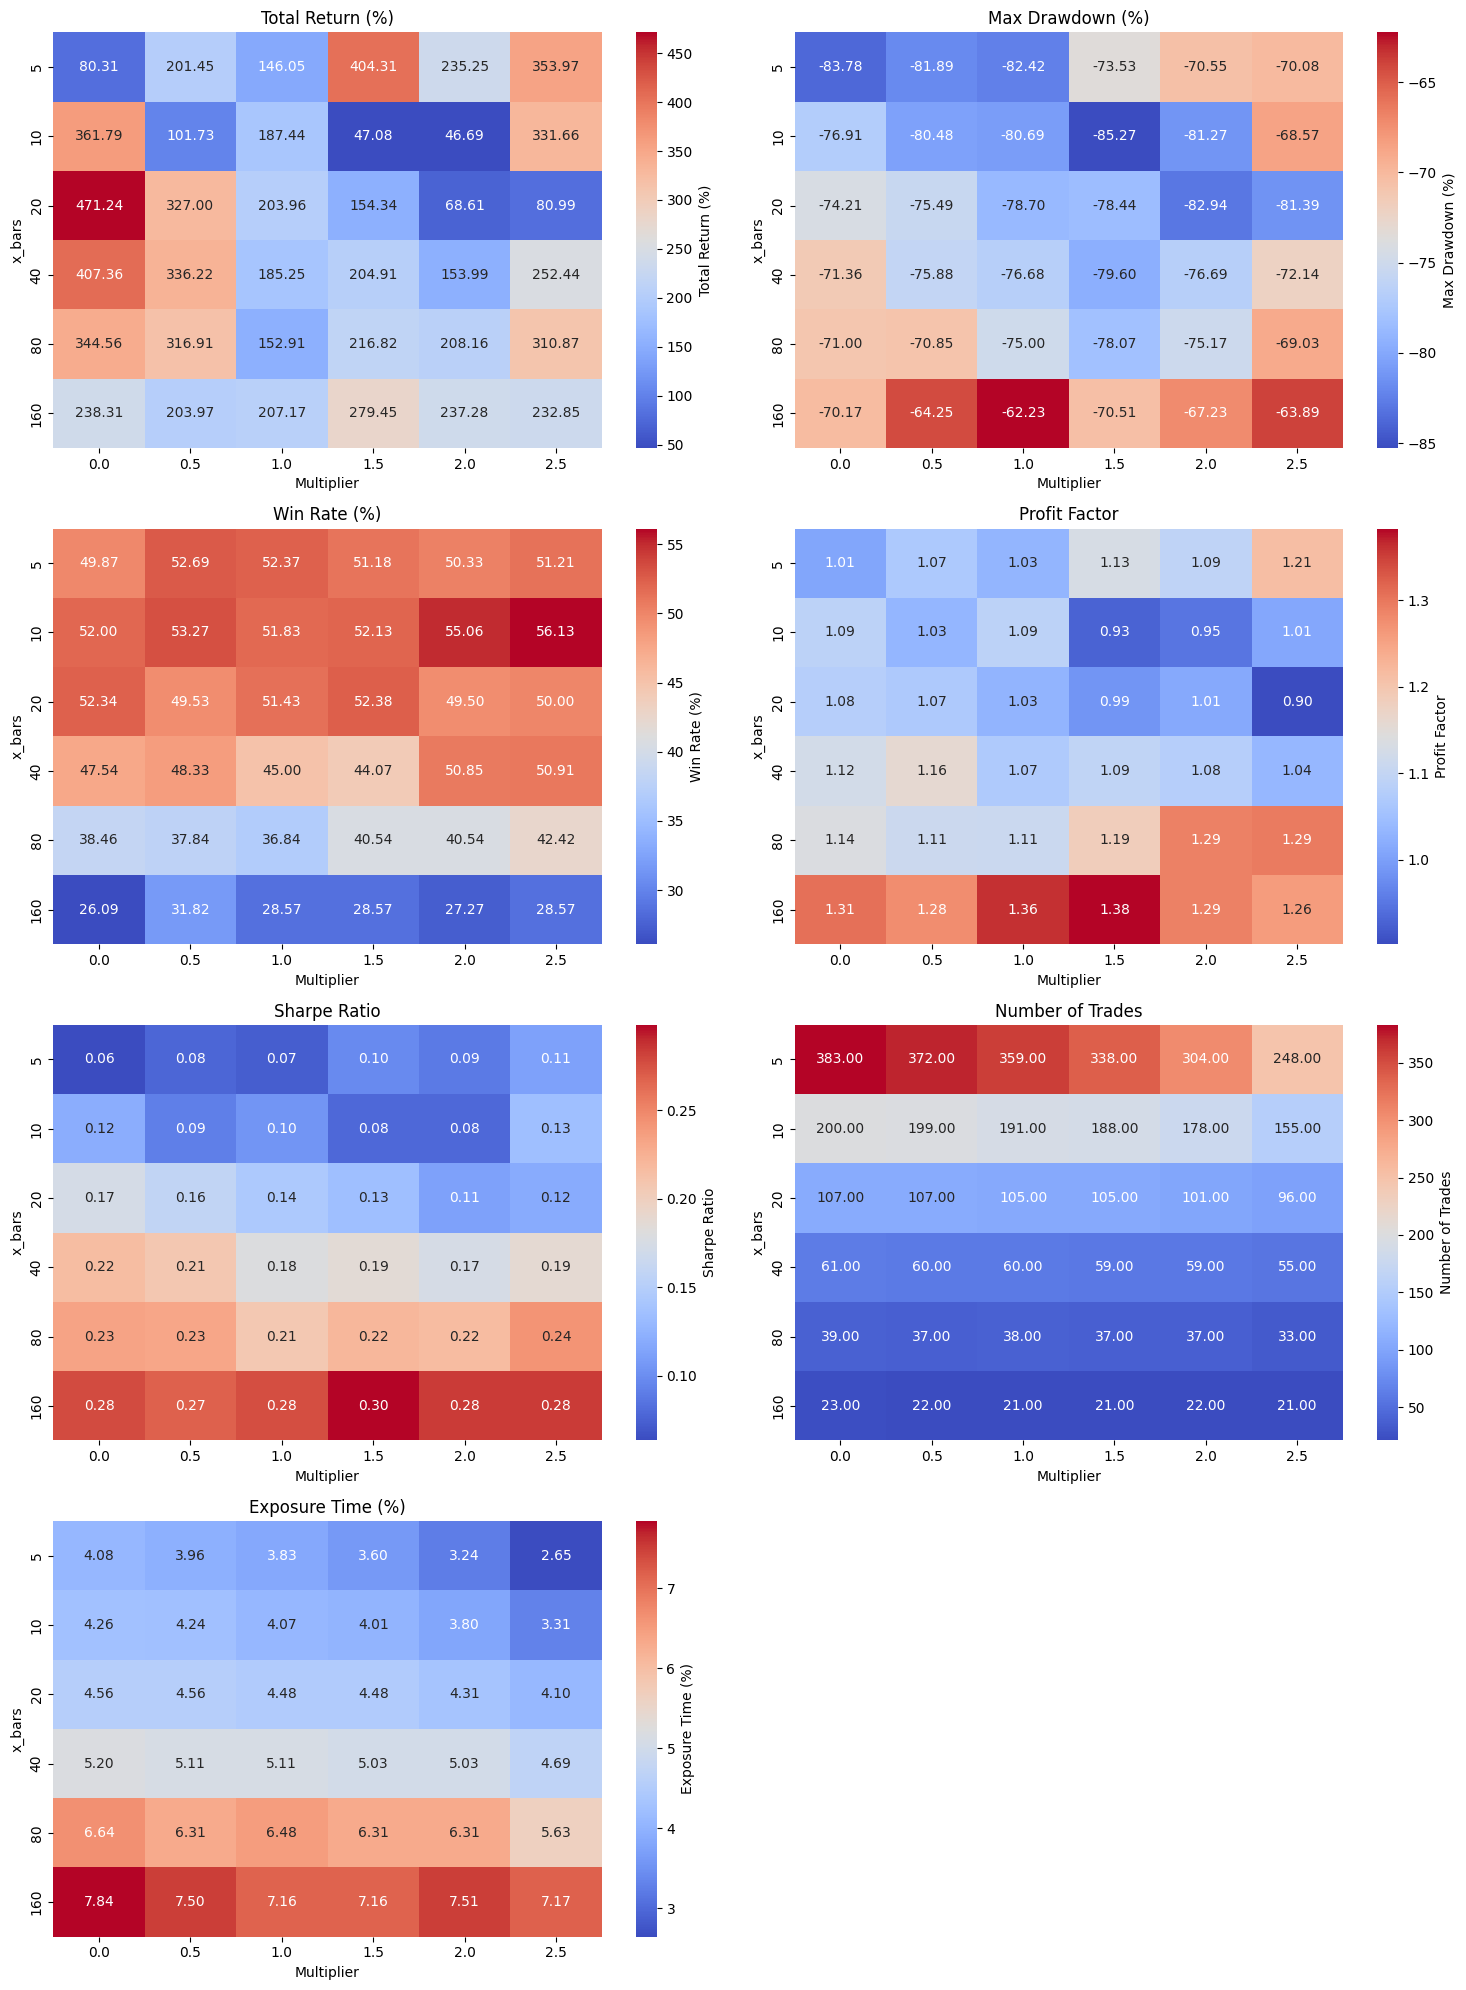

In [7]:
plot_heatmaps(results_df, keys=[
    'Total Return (%)', 'Max Drawdown (%)', 'Win Rate (%)', 
    'Profit Factor', 'Sharpe Ratio', 'Number of Trades', 'Exposure Time (%)'
])

## Optimization Insights 

1. Profit Distribution and Robustness: Uneven profit distribution across parameters highlights overfitting risks. However, configurations with multiplier = 0 and x_days = 20 or 40 show high profitability, potential for further exploration and validation.

2. Drawdowns and Risk Management: Persistent high drawdowns, despite already using stop-loss, indicate the need for more enhanced risk controls. A volatility-based stop-loss (e.g., 2 standard deviations) or dynamic position sizing may help reduce excessive losses.

2. Winrate and Sharpe Ratio: With winrates of 45-56%, the strategy aligns well with trend-following principles but suffers from high return volatility, resulting in a low Sharpe ratio. Improving signal quality and mitigating drawdowns can enhance risk-adjusted returns.

3. Trade Frequency: Longer periods (x_days > 40) reduce trade frequency, risking over-reliance on fewer trades. Prioritizing x_days = 20 ensures adequate trades for statistical robustness.

### Next move
Optimize parameters (multiplier = 0, x_days = 20) and validate robustness on out-of-sample data.